# Representation of media outlets on German-speaking Reddit, 2019-2021

This notebook analyzes which media outlets are most prominently featured
on the main German-language subreddit "[/de](https://www.reddit.com/r/de)."


The main results of this analysis are as follows:
- More than half of all posts to the "/de" subreddit are links to external websites.
- **spiegel.de** is the website with the most submissions, closely followed by **sueddeutsche.de**.
- The highest scoring submissions to this subreddit are links to images, but the most-discussed submissions
  are those that link to media sources.
- The engagement a submission produces in terms of the number of comments depends strongly on the news source: the median submission to tagesspiegel.de, n-tv.de, or spiegel.de generates around 30 comments, while submissions to taz.de or sueddeutsche.de receive only about 10 comments.

Contents:
- [Data preparation](#prep)
- [Data overview](#data_overview)
- [Sources of submissions](#sources)
- [Engagement: Score and number of comments](#engagement)





## Data preparation <a class="anchor" id="prep"></a>

### Imports

In [1]:
from urllib.parse import urlparse
import pickle
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import arrow

# helper class to download and update Reddit submissions
import SubmissionDownloader

DOWNLOAD = False # whether to re-download the data
YEARS = [2019, 2020, 2021]

# plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

my_theme = theme_bw() + theme(text=element_text(family="Arial"))

### Download data

The Reddit API does not allow the collection of historical data, such as the daily submissions to a subreddit. I therefore use the Pushshift API to download all submissions to the /de subreddit for 2019, 2020 and 2021. The submissions are collected in the Pushshift database at the time of posting, so the scores (as well as possible edits) are not captured by the database. In a second step, I use the official reddit API to update all submissions such that they have the most recents scores.

If you want to download the data yourself, you need to set up a [`praw.ini` file](https://praw.readthedocs.io/en/stable/getting_started/configuration/prawini.html) with a `client_id` and `client_secret`, and set variable `DOWNLOAD` above to `True`. The following two steps can take a couple of hours. The requests to the Pushshift API are cached. For the Reddit API, I implemented a simple caching solution using the [`diskcache`](https://github.com/grantjenks/python-diskcache) library.

In [2]:
if DOWNLOAD:
    sd = SubmissionDownloader.SubmissionDownloader('pushshift_cache', 'reddit_cache')
    for year in YEARS:
        print(year)
        # download all submissions for three years via the Pushshift API
        submissions = sd.get_subreddit_submissions(
            subreddit = 'de',
            start = arrow.get(f'{year}-01-01T00:00:00.000+01:00'),
            end = arrow.get(f'{year}-12-31T23:59:59.000+01:00'), wait_time = 1)
        # update attributes with most recent data from the Reddit API
        submissions = sd.update_subreddit_submissions(submissions,
            attributes = ['score', 'upvote_ratio', 'removed_by_category', 'num_comments'])
        # save result
        with open(f'submissions_{year}.pickle', 'wb') as f:
            pickle.dump(submissions, f, pickle.HIGHEST_PROTOCOL)

# load saved files
submissions = []
for year in YEARS:
    with open(f'submissions_{year}.pickle', 'rb') as f:
        submissions += pickle.load(f)

print(len(submissions))

187072


### Clean data

This code turns the data set into a DataFrame and does some light cleaning. 
All submissions that were deleted by Reddit or the moderators are also removed from the dataset.

In [3]:
df = pd.DataFrame(submissions)
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s', utc=True).dt.tz_convert('Europe/Berlin')
df = df[df['datetime'].dt.year.isin(YEARS)]
# only retain posts that were not removed by Reddit, moderators, etc.
df = df[df['removed_by_category'].isnull()]
# only retain subset of data
df = df[['id', 'datetime', 'author', 'title', 'url', 'score', 'num_comments', 'full_link']]
# helper columns
df['N'] = 1
# get domain from URLs

def remove_prefixes(str, prefixes):
    for prefix in prefixes:
        str = str.removeprefix(prefix)
    return str

parse_url = lambda url: remove_prefixes(urlparse(url).netloc, 
    ['www.', 'www1.', 'i.', 'v.', '1.', 'm.', 'old.'])
df['domain'] = df['url'].apply(parse_url)
# recode domains
df['domain'] = df['domain'].replace({
    'redd.it': 'reddit.com',
    '': 'reddit.com',
    'youtu.be': 'youtube.com',
    'spon.de': 'spiegel.de',
    'sz.de': 'sueddeutsche.de',
    'sz-magazin.sueddeutsche.de': 'sueddeutsche.de'
})
df = df.drop_duplicates()

df.shape

(115452, 10)

The final dataset contains 115,452 submissions.

## Data overview <a class="anchor" id="data_overview"></a>

The following figure shows the daily number of submissions to the "/de" subreddit. 
In 2019, there were about 150 daily submissions, which dropped in a short span of time to about 100. 
This may be due to a change in moderation rules, such that more submissions were removed.
In 2021, there is a spike around the Federal Election in September, and a decrease of activity in November and December.
Interestingly, there is no clearly discernible Covid-related bump in March 2020.



In late 2020 and early 2021 there are a few days with zero submissions. This is due to a current problem with the Pushshift API that might be fixed by a future update. Overall, there are 19 days with missing data.

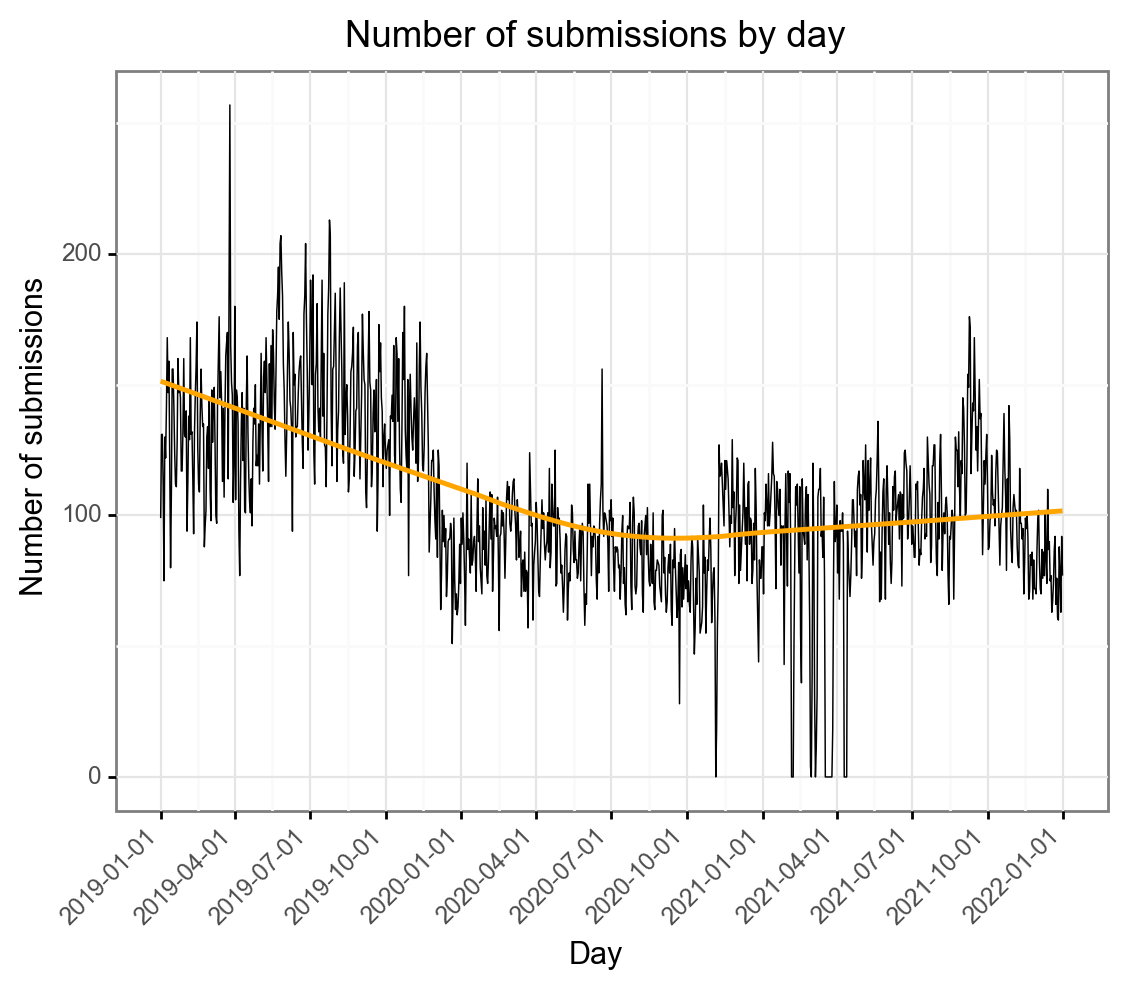

<ggplot: (713649393)>

In [4]:
by_day = df.resample('D', on = 'datetime')['N'].count().reset_index()

ggplot(by_day, aes('datetime', 'N')) + \
    geom_line(size = 0.3) + \
    geom_smooth(data=by_day[by_day['N'] > 0], color='orange', method='lowess', se=False) + \
    scale_x_date(date_breaks='3 months') + \
    labs(title="Number of submissions by day", x="Day", y="Number of submissions") + \
    my_theme + \
    theme(axis_text_x=element_text(rotation=45, hjust=1))

As the following table shows, out of the 1077 days with non-zero submissions, the average number of submissions is about 107, with a minimum of 4 (probably also a Pushshift API problem), and a maximum of 257.

In [5]:
print(len(by_day.query('N==0')))
by_day.query('N>0')['N'].describe().round(1).reset_index()

19


,index,N
0,count,1077.0
1,mean,107.2
2,std,31.3
3,min,4.0
4,25%,85.0
5,50%,101.0
6,75%,125.0
7,max,257.0


## Sources of submissions <a class="anchor" id="sources"></a>

The first interesting question regards the number of submissions from different websites. 
This first table shows that posts to other sites on Reddit, video and image posts hosted by Reddit,
and text posts that don't link directly to another site comprise about 42% of submission. 
The remaining 58% of submissions are links to other domains, such as spiegel.de or sueddeutsche.de.

In [6]:
def counts_table(by):
    tab = df.groupby('domain')['N'].count().reset_index()
    tab.sort_values('N', ascending=False, inplace=True)
    tab['%'] = 100 * tab['N'] / tab['N'].sum()
    tab['Cumul. %'] = tab['%'].cumsum()
    return tab[['domain', 'N', '%', 'Cumul. %']]

counts_table('domain').head(5).round(1)

,domain,N,%,Cumul. %
2488,reddit.com,48615,42.1,42.1
2731,spiegel.de,5704,4.9,47.0
2824,sueddeutsche.de,5676,4.9,52.0
3350,youtube.com,5495,4.8,56.7
1511,imgur.com,5163,4.5,61.2


For the remainder of the analysis, I'll restrict attention to submissions that are links
to external websites.
The following table shows the distribution of domains, ordered by popularity. Although there
are over 3,300 unique domains in the dataset, submissions to the 10 top domains account for
more than half of all submissions. 
Besides youtube.com (video content) and imgur.com (image content), the remaining websites
are all 'traditional' news outlets.

In [7]:
df = df[df['domain'] != 'reddit.com']  # remove self-posts

domains = counts_table('domain')
print("# of unique domains: ", len(domains))
domains.head(20).round(1).reset_index()

# of unique domains:  3387


,index,domain,N,%,Cumul. %
0,2730,spiegel.de,5704,8.5,8.5
1,2823,sueddeutsche.de,5676,8.5,17.0
2,3349,youtube.com,5495,8.2,25.2
3,1511,imgur.com,5163,7.7,33.0
4,3362,zeit.de,2991,4.5,37.4
5,2879,tagesschau.de,2846,4.3,41.7
6,1065,faz.net,1885,2.8,44.5
7,1401,heise.de,1849,2.8,47.3
8,2880,tagesspiegel.de,1834,2.7,50.0
9,3233,welt.de,1561,2.3,52.4


The following plot shows the popularity of different news outlets throughout the year.
The plot shows how many of the weekly submissions are accounted for by the six most 
popular news sources (including youtube.com). Although the data is rather noisy, the trends cautiously
indicates a stable trajectory for spiegel.de (possibly with a slight increase in later years), sueddeutsche.de, 
zeit.de, and faz.net. The trajectory for tagesschau.de, on the other hand, is on
the upswing, while youtube.com's share of submissions has declined considerably.

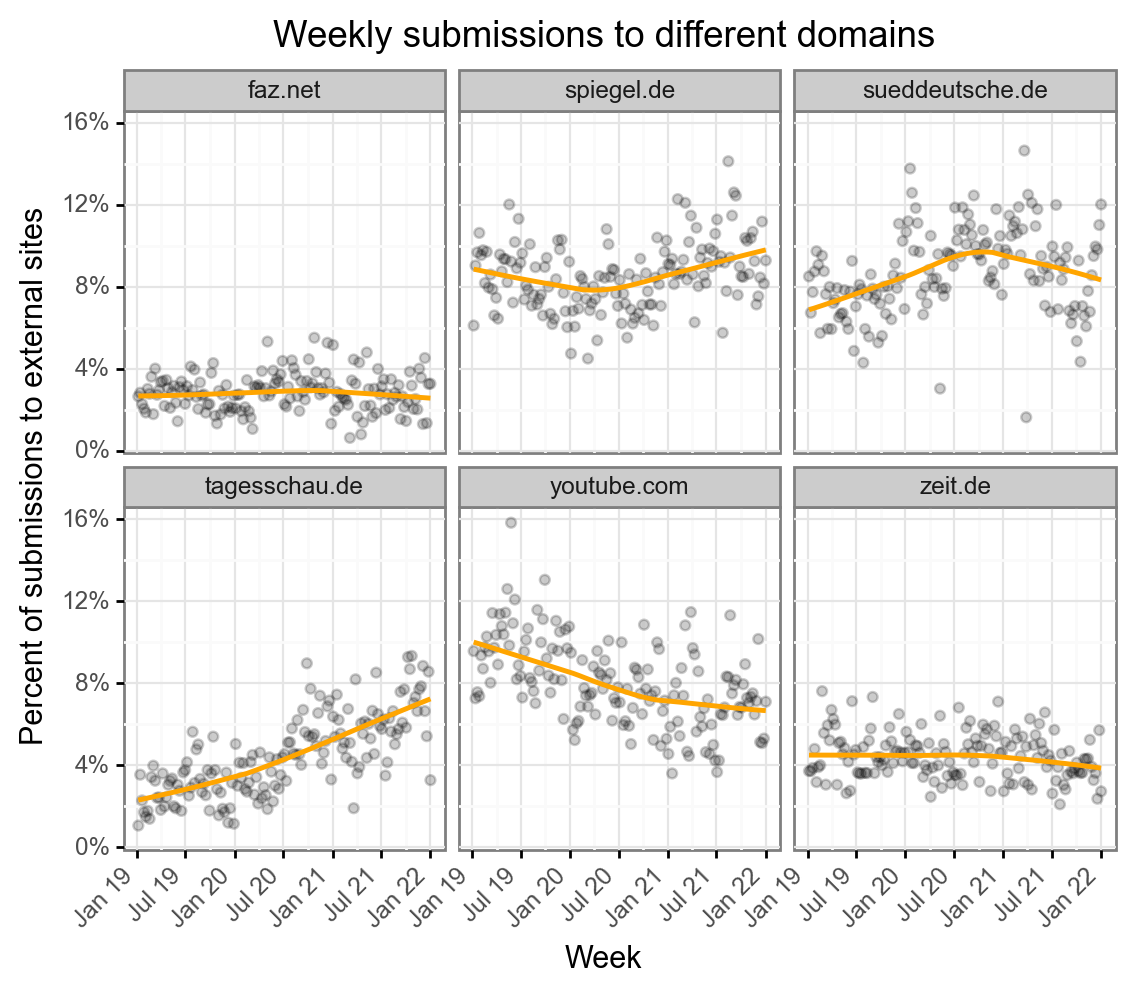

<ggplot: (714901209)>

In [8]:
by_week_domain = df.groupby(
    [pd.Grouper(freq='1W', key='datetime'), 'domain'])['N'].count().reset_index()
by_week_domain['N_by_week'] = by_week_domain.groupby('datetime')['N'].transform('sum')
by_week_domain['%'] = by_week_domain['N'] / by_week_domain['N_by_week']

subset = ['spiegel.de', 'sueddeutsche.de', 'tagesschau.de', 
    'zeit.de', 'youtube.com', 'faz.net']

ggplot(by_week_domain[by_week_domain['domain'].isin(subset)], aes('datetime', '%')) + \
    facet_wrap('domain') + \
    geom_point(alpha=0.2) + \
    scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) + \
    scale_x_date(date_breaks='6 months', date_labels='%b %y') + \
    geom_smooth(color='orange', se=False) + \
    labs(x='Week', y='Percent of submissions to external sites', 
         title='Weekly submissions to different domains') + \
    my_theme +\
    theme(axis_text_x=element_text(rotation=45, hjust=1))

This final plot measures the weekly diversity of news sources. Diversity, as measured by entropy, is highest if many 
news sources are equally represented, and is lowest when all submissions are to a small
number of sites. Because the absolute value of entropy is hard to interpret, I plot change in entropy
relative to the first data point. The results indicate that diversity might be declining, however,
the relative change is very small.

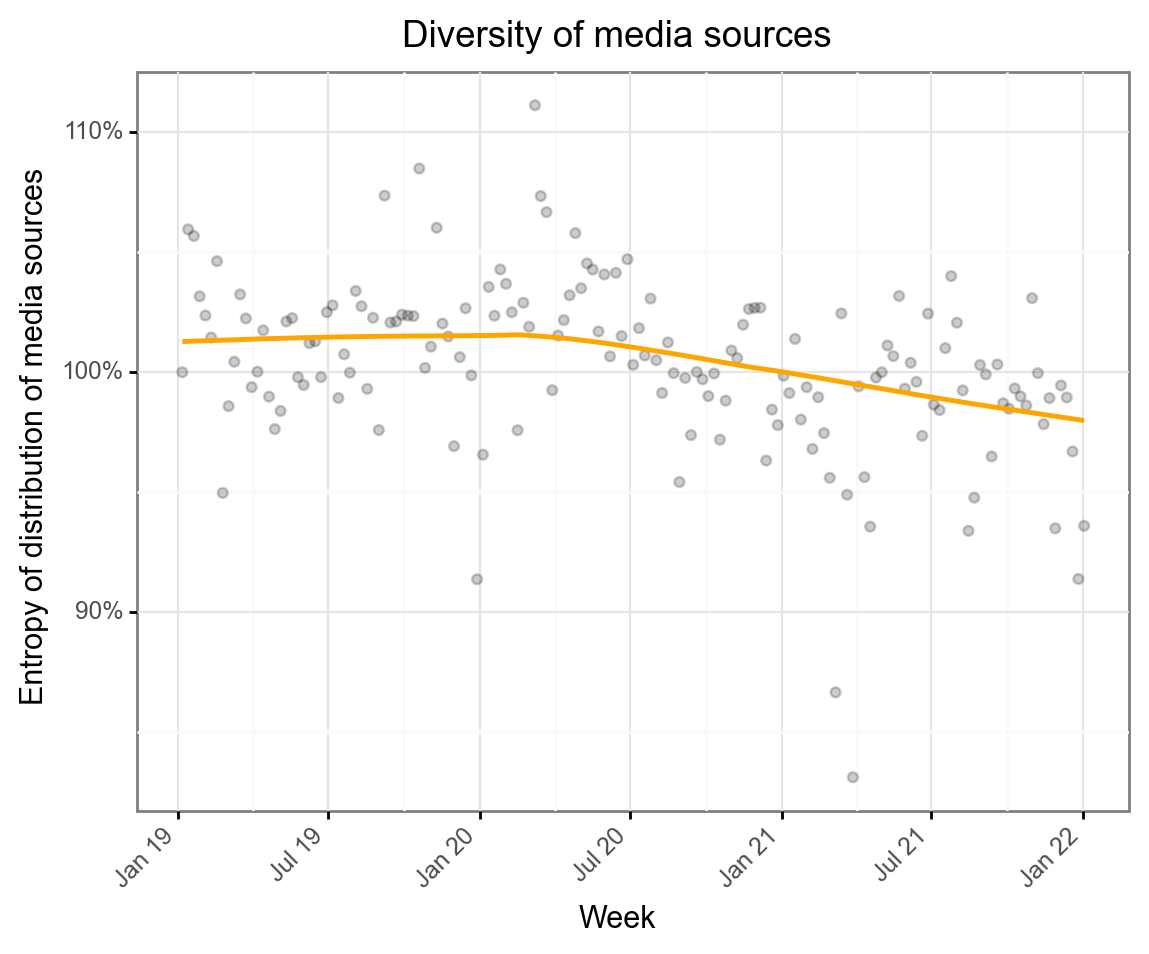

<ggplot: (715221748)>

In [9]:
def entropy(s):
    s = s / s.sum()  # normalize
    return -np.sum(s * np.log(s))

entropy = by_week_domain.groupby('datetime')['N'].agg(entropy).reset_index()
entropy['entropy_rel'] = entropy['N'] / entropy['N'].iloc[0]

ggplot(entropy, aes('datetime', 'entropy_rel')) + \
    geom_point(alpha=0.2) + \
    geom_smooth(color='orange', se=False) + \
    scale_x_date(date_breaks='6 months', date_labels='%b %y') + \
    scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) + \
    labs(x='Week', y='Entropy of distribution of media sources', 
         title='Diversity of media sources') + \
    my_theme +\
    theme(axis_text_x=element_text(rotation=45, hjust=1))
        

## Engagement: Score and number of comments <a class="anchor" id="engagement"></a>

Users on Reddit can upvote and downvote submissions, resulting in a 'score' for each submission. 
This is used by Reddit to display the most interesting submissions first. Users can also comment
on submissions, and the dataset contains the number of comments a submission has generated.

The median submission generates a score of 14, with 9 comments. 50% of submissions have a score
between 2 and 58, and between 2 and 31 comments.

In [10]:
desc = lambda col: df[col].describe().reset_index().round(1)
pd.concat(map(desc, ['score', 'num_comments']), axis=1)

,index,score,index,num_comments
0,count,66837.0,count,66837.0
1,mean,98.7,mean,32.4
2,std,399.0,std,71.9
3,min,0.0,min,0.0
4,25%,2.0,25%,2.0
5,50%,14.0,50%,9.0
6,75%,58.0,75%,31.0
7,max,23534.0,max,2680.0


Both the score and the number of comments the median submission receive have changed considerable over time.
There is clearly a "bump" around late 2020, coinciding with the the large reduction in the number of submissions.
The largest increases are observed in 2021, which may reflect the increasing popularity of Reddit in Germany.

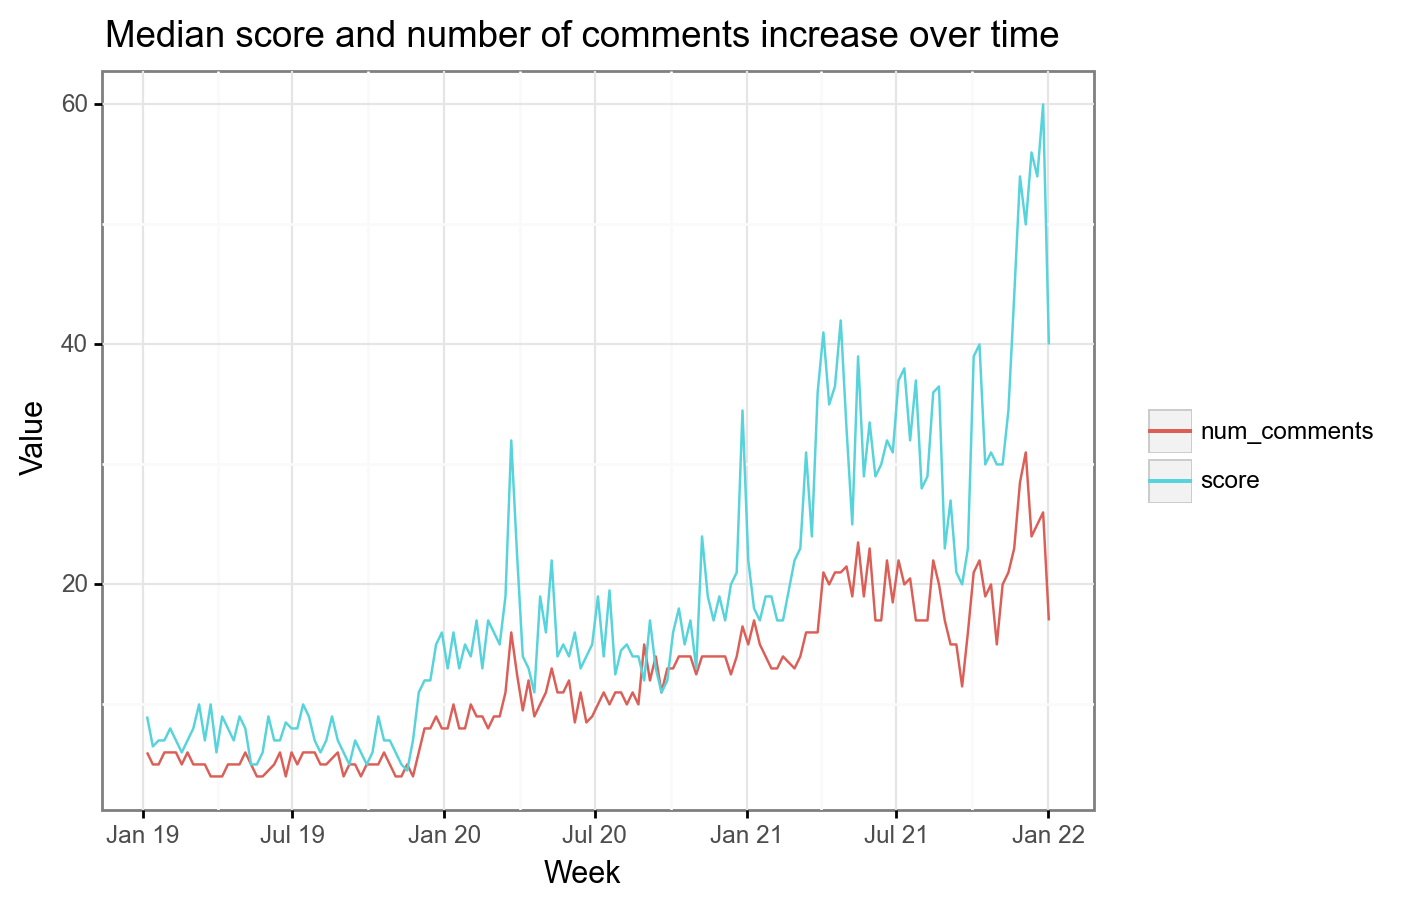

<ggplot: (714905956)>

In [11]:
by_week_engagement = df.resample('1W', on='datetime')[['score', 'num_comments']].median().reset_index()
by_week_engagement = by_week_engagement.melt(id_vars='datetime')

ggplot(by_week_engagement, aes('datetime', 'value', color='variable')) + \
    geom_line() + \
    scale_x_date(date_breaks='6 months', date_labels='%b %y') + \
    labs(title='Median score and number of comments increase over time', 
         x='Week', y='Value', color='') + \
    my_theme

The correlation between the score and the number of comments is 0.53. The fact that this correlation
is not perfect can be seen by inspecting the submissions with the highest score, and separately
the submissions with the highest number of comments. As seen below, these distributions are quite dissimilar.
All of the 10 most highly voted submission are links to images (imgur.com/Facebook), but many of
the most-discussed submissions are links to news stories. Hence, images generate upvotes, but news stories 
generate discussion.

In [12]:
cols = ['datetime', 'domain', 'score']
df.sort_values('score', ascending=False)[cols].iloc[:10].style.hide_index()

datetime,domain,score
2020-08-28 20:00:20+02:00,imgur.com,23534
2020-07-15 13:13:37+02:00,gfycat.com,13561
2021-03-11 07:46:29+01:00,imgur.com,11951
2021-05-19 10:16:32+02:00,scontent-muc2-1.xx.fbcdn.net,11271
2021-02-09 11:57:44+01:00,imgur.com,11106
2020-11-13 10:18:18+01:00,imgur.com,10242
2021-07-21 13:43:16+02:00,imgur.com,9977
2020-10-02 07:00:13+02:00,twitter.com,9602
2021-01-17 10:22:22+01:00,imgur.com,9585
2021-06-18 11:01:46+02:00,imgur.com,9531


In [13]:
cols = ['datetime', 'domain', 'title', 'num_comments']
df.sort_values('num_comments', ascending=False)[cols].iloc[:10].style.hide_index()

datetime,domain,title,num_comments
2019-05-26 18:00:27+02:00,imgur.com,18:00 Uhr EU-Wahlprognose für DE,2680
2021-02-26 08:20:34+01:00,rnd.de,"""Diese kleinen Pisser"": Bayern-3-Moderator beleidigt koreanische Pop-Band und löst Rassismus-Eklat aus",2162
2020-10-11 09:29:24+02:00,scontent-frt3-2.xx.fbcdn.net,Wie weit sind wir vom nachaltigen Fleischkonsum entfernt?,1883
2020-12-13 11:24:20+01:00,tagesschau.de,Merkel kündigt harten Lockdown ab 16. Dezember an,1792
2021-04-15 09:21:19+02:00,businessinsider.de,Berliner Mietendeckel: Bundesverfassungsgericht kippt umstrittenes Gesetz,1702
2021-12-06 09:50:04+01:00,spiegel.de,SPD gibt Ministerien bekannt: Karl Lauterbach wird Gesundheitsminister,1612
2020-08-11 08:27:33+02:00,scontent-frt3-1.xx.fbcdn.net,Frau revolutioniert Männerfussball,1501
2020-10-02 07:00:13+02:00,twitter.com,Donald Trump hat Corona.,1428
2021-07-22 07:55:51+02:00,imgur.com,Kulturschock des Tages - So macht man im Osten Jägerschnitzel..?,1413
2021-10-20 06:54:17+02:00,t3n.de,Krypto-Kraftwerk produziert Bitcoin für 45 Millionen Dollar statt Strom für Zehntausende.,1297


Looking at the most prominent domains in terms of number of submissions, I now study the 
score and the number of comments the median submission generates. Because of the fluctuation in the score
and number of comments over time, I restrict attention to the year 2021. 
Interestingly, there is wide variation for both of these outcomes across domains. For instance, the median submission
to tagesspiegel.de, n-tv.de, or spiegel.de generates around 30 comments and a score of about 50.
However, submissions to taz.de or sueddeutsche.de receive only about 10 comments, and a score
of about 10.

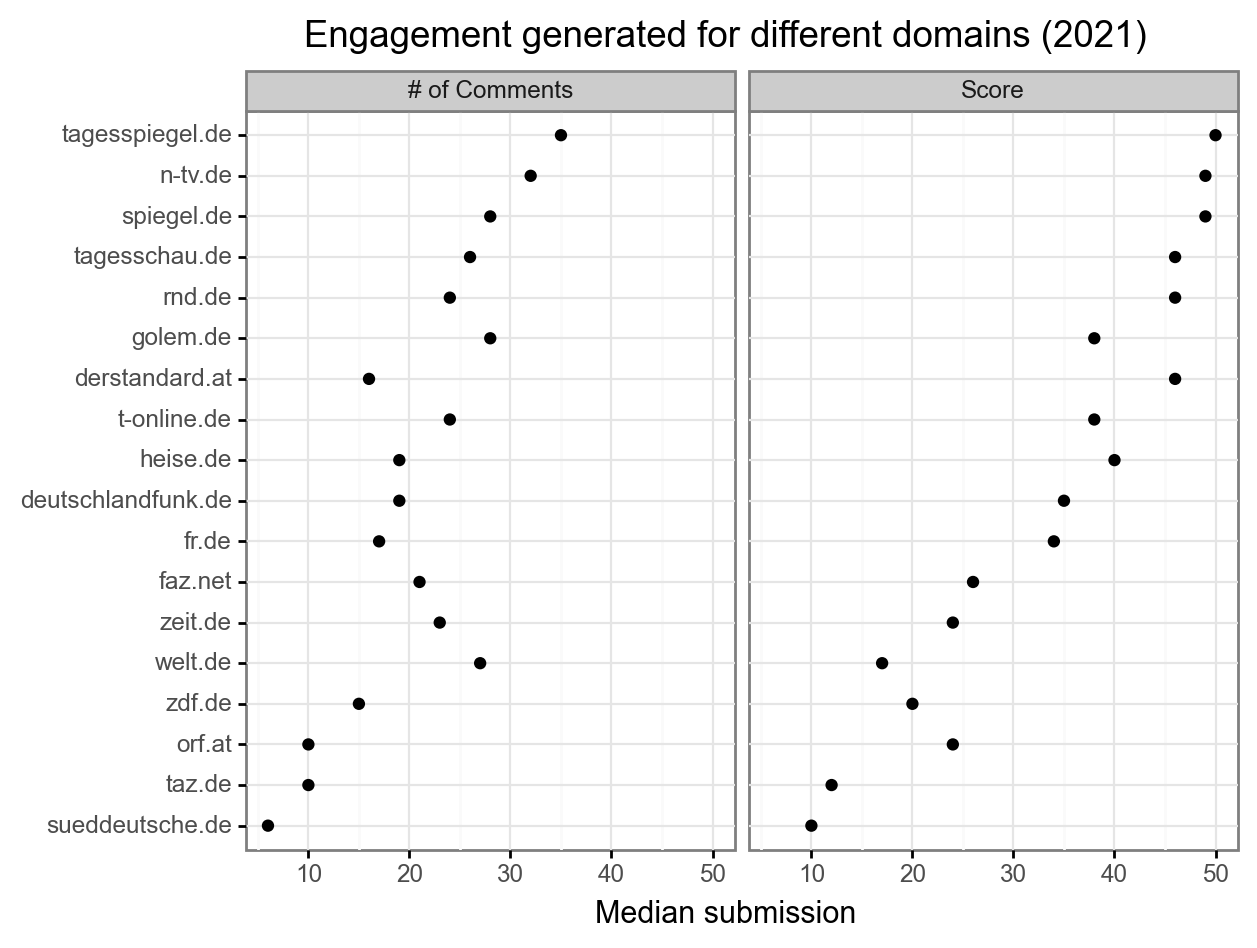

<ggplot: (715384814)>

In [14]:
df['year'] = df['datetime'].dt.year
by_domain = df.\
    query('year==2021').\
    groupby(['domain']).\
    agg({ 'N': 'count', 'score': 'median', 'num_comments': 'median'}).\
    reset_index().\
    sort_values('N', ascending=False).\
    drop('N', axis=1).\
    head(20).\
    query('domain != "imgur.com" & domain != "youtube.com"').\
    melt(id_vars=['domain']).\
    replace({'variable': {'num_comments': '# of Comments', 'score': 'Score'}})

ggplot(by_domain, aes(y='reorder(domain, value)', x='value')) + \
    facet_wrap('variable') + \
    geom_point() + \
    labs(title='Engagement generated for different domains (2021)', x='Median submission', y='') + \
    my_theme

A final plot breaks down the median score across different media outlets by week. 
Over the years, median scores for spiegel.de and tageschau.de have been strongly increasing. 
This also true for faz.net, to a lesser extent. 
We see that submissions to sueddeutsche.de and youtube.com generate few comments, despite
being among the most-submitted sites on the subreddit.

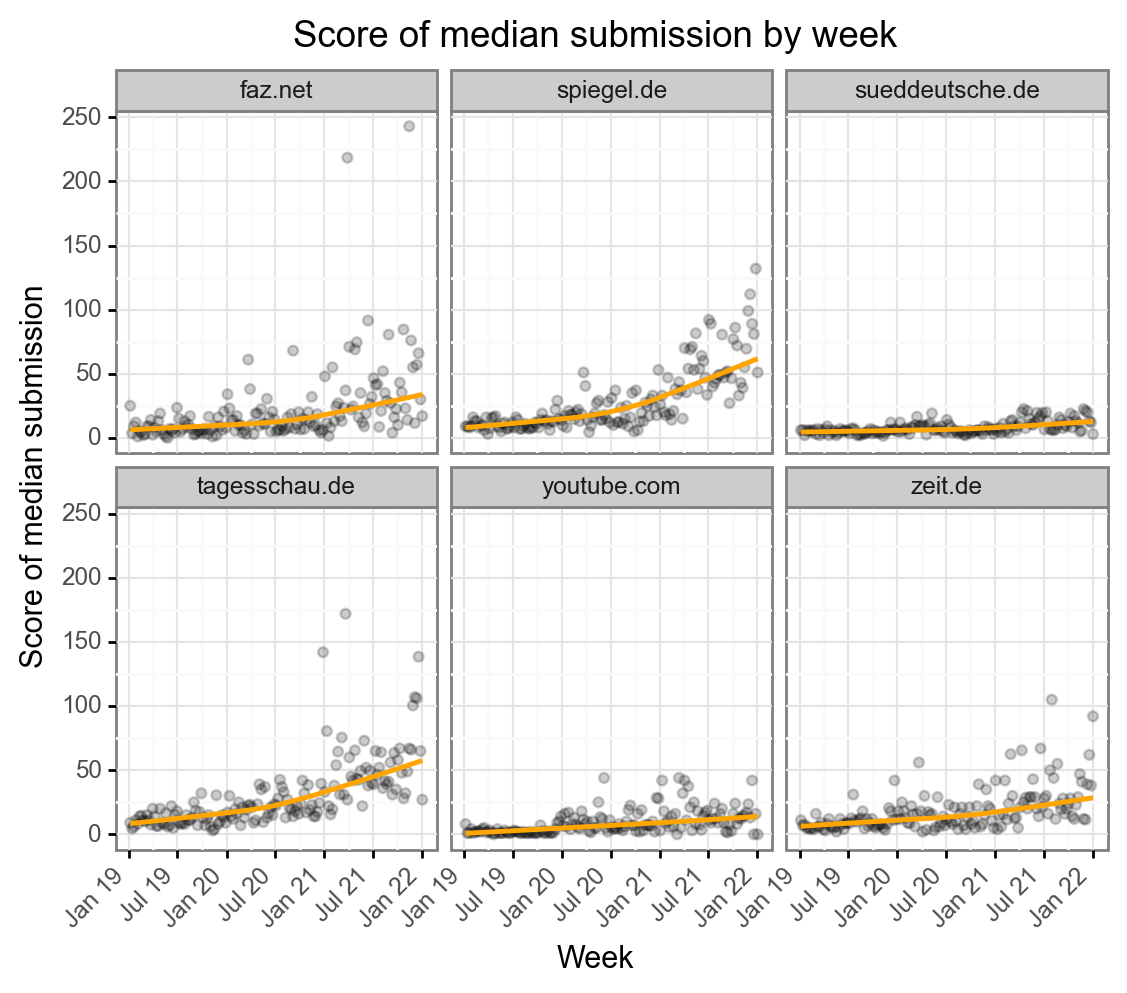

<ggplot: (715491325)>

In [15]:
by_week_domain = df.groupby(
    [pd.Grouper(freq='1W', key='datetime'), 'domain'])['score'].median().reset_index()

ggplot(by_week_domain[by_week_domain['domain'].isin(subset)], aes('datetime', 'score')) + \
    facet_wrap('domain') + \
    geom_point(alpha=0.2) + \
    geom_smooth(color='orange', se=False) + \
    scale_x_date(date_breaks='6 months', date_labels='%b %y') + \
    labs(x='Week', y='Score of median submission', 
         title='Score of median submission by week') + \
    my_theme +\
    theme(axis_text_x=element_text(rotation=45, hjust=1))